In [90]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt

In [34]:
def str2ary(str_):
    x = str_.replace("]","").replace("[","")
    x = x.split(",")
    assert(not len(x)%2)
    lst = []
    for i in range(0, len(x), 2):
        tmp  = tuple([int(x[i]), int(x[i+1])])
        lst.append(tmp)
    print(lst)
x = "[[2149, 2349], [4536, 4844], [3539, 3779]]"
str2ary(x)

[(2149, 2349), (4536, 4844), (3539, 3779)]


In [53]:
labels = os.path.join("Seq2SeqAnom", "data","labeled_anomalies.csv")
lbls = pd.read_csv(labels)
lbls.head()

,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307


In [63]:
test_lbls =dict()
for i in lbls.iterrows():
    test_lbls[i[1]['chan_id']] =  i[1]['anomaly_sequences']

In [5]:
os.getcwd()

'/Users/juanrodriguez/PycharmProjects/pythonProject1'

In [20]:
glb = glob.glob(os.path.join("Seq2SeqAnom", "data","train","*"))

In [71]:
channels = []
trn_data  = []
for g in glb:
    channels.append(g.split("/")[-1])
    trn_data.append(np.load(g))


In [80]:
trn_data = np.array(trn_data, dtype=object)

In [78]:
trn_data[0][0:10]

array([[0.45098182, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.41176651, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.41176651, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

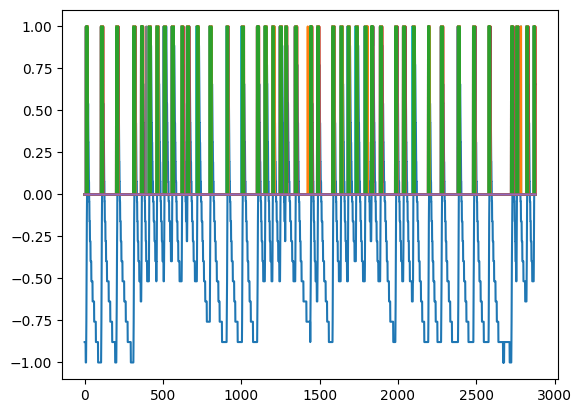

In [87]:
plt.plot(trn_data[1][0:-1])

In [95]:
sample = trn_data[1]

In [220]:
X_trn = []
Y_trn = []
for i in range(0,sample.shape[0], 9):
    if i+10 > sample.shape[0]:
        break
    X_trn.append(sample[i:i+9, :].reshape((25,9)))
    Y_trn.append(sample[i+10].reshape((25,1)))


In [216]:
Y_trn[0]

array([[-0.87841018,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [224]:
X_trn = tf.constant(X_trn)
Y_trn = tf.constant(Y_trn)
X_trn.shape

TensorShape([319, 25, 9])

In [262]:
nb_epoch = 200
batch_size = 64
input_dim = sample.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4
learning_rate = 1e-5

In [263]:
input_layer = tf.keras.layers.Input(shape=(input_dim, 9))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(1, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
print(autoencoder.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 25, 9)]           0         
                                                                 
 dense_64 (Dense)            (None, 25, 14)            140       
                                                                 
 dropout_22 (Dropout)        (None, 25, 14)            0         
                                                                 
 dense_65 (Dense)            (None, 25, 7)             105       
                                                                 
 dense_66 (Dense)            (None, 25, 4)             32        
                                                                 
 dense_67 (Dense)            (None, 25, 7)             35        
                                                                 
 dropout_23 (Dropout)        (None, 25, 7)             0   

In [264]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [265]:
history = autoencoder.fit(X_trn, Y_trn,
                    epochs=nb_epoch,
                    batch_size=1,
                    shuffle=True,
                    verbose=1,
                    ).history

319/319 [==============================] - 0s 1ms/step - loss: 0.0240 - accuracy: 0.9392
Epoch 167/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0239 - accuracy: 0.9389
Epoch 168/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0239 - accuracy: 0.9393
Epoch 169/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0243 - accuracy: 0.9389
Epoch 170/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0241 - accuracy: 0.9389
Epoch 171/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0239 - accuracy: 0.9392
Epoch 172/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0244 - accuracy: 0.9389
Epoch 173/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0239 - accuracy: 0.9393
Epoch 174/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0243 - accuracy: 0.9392
Epoch 175/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0240 - a

In [270]:
X_trn[0].shape

TensorShape([25, 9])

In [271]:
x = np.array(X_trn[0])
x.shape
x = x.reshape(1,25,9)

In [272]:


autoencoder.predict(x)

1/1 [==============================] - 0s 157ms/step


array([[[-0.54163295],
        [ 0.00648695],
        [ 0.00648695],
        [ 0.00648695],
        [ 0.00648695],
        [ 0.1910774 ],
        [ 0.00648695],
        [ 0.00648695],
        [ 0.00071188],
        [ 0.00648695],
        [ 0.00648695],
        [-0.00163859],
        [ 0.00648695],
        [-0.00553543],
        [ 0.00648695],
        [ 0.00648695],
        [ 0.00267781],
        [ 0.00648695],
        [ 0.00648695],
        [ 0.00131044],
        [ 0.00648695],
        [ 0.00648695],
        [ 0.4406498 ],
        [ 0.00648695],
        [-0.00220561]]], dtype=float32)

In [255]:
x = np.array(X_trn[0])
x = x.reshape(1,25,9)
Y_trn[0]

<tf.Tensor: shape=(25, 1), dtype=float64, numpy=
array([[-0.87841018],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 1.        ],
       [ 1.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])>

In [253]:
autoencoder.predict(x)

1/1 [==============================] - 0s 15ms/step


array([[[-0.6813766 ],
        [ 0.0129029 ],
        [ 0.01107617],
        [ 0.0129029 ],
        [ 0.0129029 ],
        [ 0.2532945 ],
        [ 0.0129029 ],
        [ 0.0129029 ],
        [ 0.0141429 ],
        [ 0.0129029 ],
        [ 0.0129029 ],
        [ 0.03108365],
        [ 0.0129029 ],
        [ 0.01668264],
        [ 0.0129029 ],
        [ 0.0129029 ],
        [ 0.00786474],
        [ 0.0129029 ],
        [ 0.0129029 ],
        [ 0.03036799],
        [ 0.0129029 ],
        [ 0.0129029 ],
        [ 0.16706328],
        [ 0.0129029 ],
        [ 0.05751929]]], dtype=float32)